In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
# Create an engine that can talk to the 'hawaii.sqlite' database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine=engine, reflect=True)

In [8]:
# Print all of the classes mapped to the Base.  A python class is essentially equivalent to an SQL table.
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table; this will update the DB as changes are made on the SQL side
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
inspector = inspect(engine)

# Precipitation Analysis

In [12]:
# Sneak peek of data table
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
# Curious to see how many dates records in this table
measurement_records_all = session.query(func.count(Measurement.date)).all()
measurement_records_all

[(19550)]

In [14]:
# Curious to see the earliest date
earliest_date = session.query(Measurement.date).order_by(Measurement.date).first()
earliest_date

('2010-01-01')

In [19]:
# Find the latest date to determine the year ago range for the assignment
prcp_data = session.query(Measurement.date, Measurement.prcp).all()
prcp_data = pd.DataFrame(prcp, columns=['date', 'precipitation']).sort_values('date')

latest_date = prcp['date'].iloc[[-1][0]]
latest_date = dt.datetime.strptime(latest_date, "%Y-%m-%d").date()

year_ago_date = latest_date - dt.timedelta(days=365)

print(f'12 Month Range:  {year_ago_date} to {latest_date}')


NameError: name 'prcp' is not defined

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_12_months_prcp_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_from_last).all()

# Convert to pandas dataframe
last_12_months_prcp_df = pd.DataFrame(last_12_months_prcp_data, columns=['date', 'prcp']).sort_values('date')
last_12_months_prcp_df = last_12_months_prcp_df.set_index('date')

# Plot data (doesn't make sense to me why we are plotting the data like this but it matches the expected results so be it!)
last_12_months_prcp_df.plot(title="Hawaii Precipiation Data", figsize=(12, 10), rot=90)

NameError: name 'year_from_last' is not defined

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = last_12_months_prcp_df.describe()
summary_stats

NameError: name 'last_12_months_prcp_df' is not defined

# Station Analysis

In [18]:
# Use the Inspector to print the column names and types from the table titled 'station'
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [146]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [80]:
# List the stations and the counts in descending order
station_activity = session.query(Measurement.station, func.count(Measurement.station)) \
                          .group_by(Measurement.station) \
                          .order_by(func.count(Measurement.station).desc()) \
                          .all()
station_activity


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [90]:
# What are the most active stations? (i.e. what stations have the most rows)?
most_active_station = station_activity[0][0]

print(f'Most Active Station: {most_active}')

Most Active Station: USC00519281


In [100]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active_station = station_activity[0][0]

most_active_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
                    .filter(Measurement.station == most_active).all()

print(f"{most_active}: [min, avg, max] = {most_active_stats}")

USC00519281: [min, avg, max] = [(54.0, 85.0, 71.66378066378067)]


<AxesSubplot:ylabel='Frequency'>

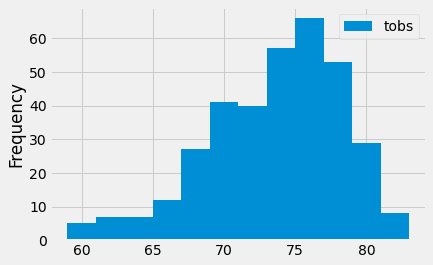

In [97]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_tobs_station = session.query(Measurement.tobs).filter(Measurement.station == most_active_station) \
                          .filter(Measurement.date \
                          .between(year_ago_date, latest_date)).all()

most_tobs_df = pd.DataFrame(most_tobs_station, columns=['tobs'])
most_tobs_df.plot(kind='hist', bins=12)

## Bonus Challenge Assignment

In [1]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

NameError: name 'session' is not defined

In [117]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_start = '2016-10-01'
trip_end = '2016-10-15'
tstats = calc_temps(trip_start, trip_end)
tmin = tstats[0][0]
tavg = tstats[0][1]
tmax = tstats[0][2]
tstats

[(71.0, 77.78947368421052, 82.0)]

(-1.0, 1.0)

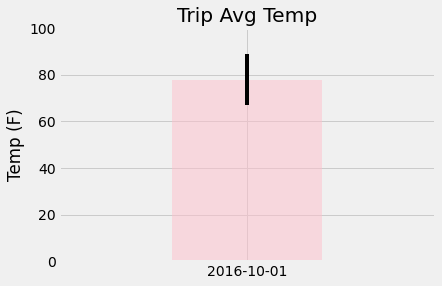

In [120]:
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = tmax-tmin

# Plot the results from your previous query as a bar chart. 
plt.bar(trip_start, tavg, yerr=yerr, color='pink', alpha = 0.5)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(0, 100)
plt.xlim(-1, 1)




In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")